Epoch 1/10, Loss: 0.1260, Validation Accuracy: 0.9680
Epoch 2/10, Loss: 0.0580, Validation Accuracy: 0.9804
Epoch 3/10, Loss: 0.0432, Validation Accuracy: 0.9824
Epoch 4/10, Loss: 0.0338, Validation Accuracy: 0.9832
Epoch 5/10, Loss: 0.0282, Validation Accuracy: 0.9834
Epoch 6/10, Loss: 0.0228, Validation Accuracy: 0.9847
Epoch 7/10, Loss: 0.0194, Validation Accuracy: 0.9847
Epoch 8/10, Loss: 0.0166, Validation Accuracy: 0.9832
Epoch 9/10, Loss: 0.0138, Validation Accuracy: 0.9844
Epoch 10/10, Loss: 0.0142, Validation Accuracy: 0.9868


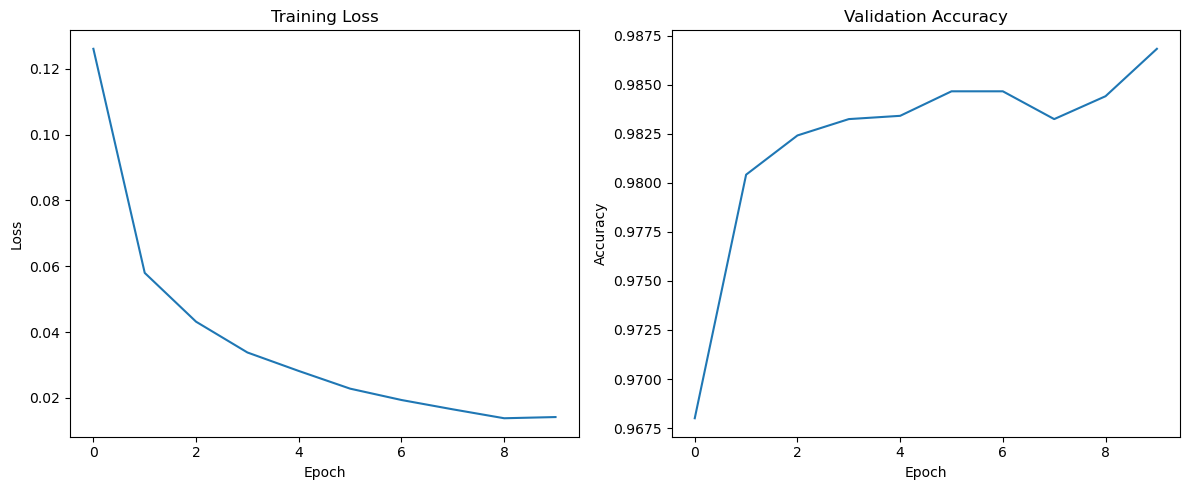

Test Accuracy: 0.9858


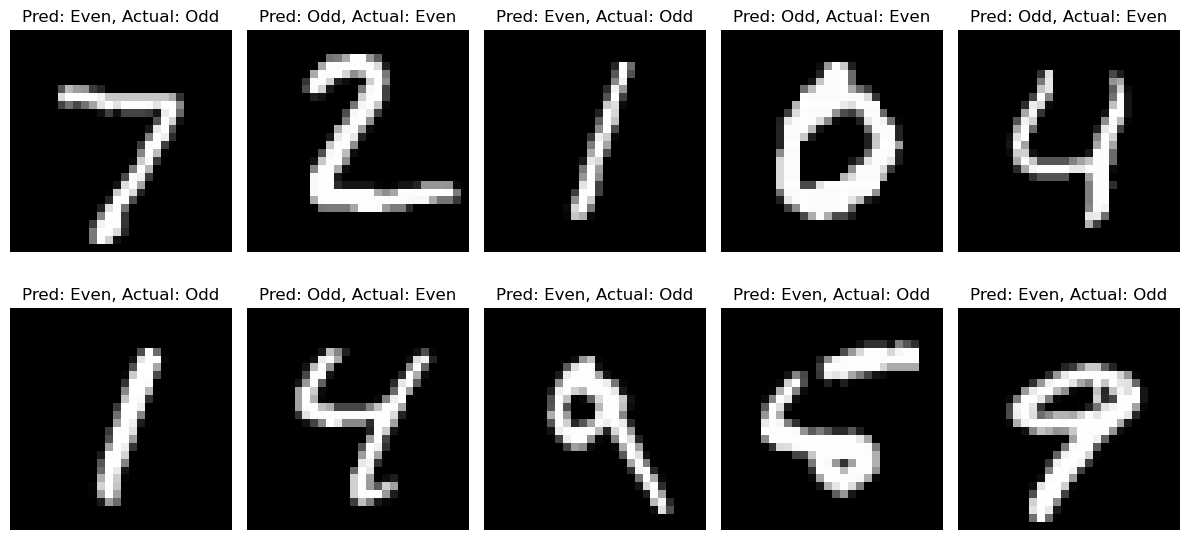

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Load and preprocess MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split the data into training and validation sets
train_size = int(0.8 * len(mnist_data))
val_size = len(mnist_data) - train_size
train_dataset, val_dataset = random_split(mnist_data, [train_size, val_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
input_dim = 28 * 28  # MNIST images are 28x28
hidden_dim = 128
model = MLP(input_dim, hidden_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, (target % 2).float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            predicted = (output > 0.5).float()
            total += target.size(0)
            correct += (predicted.squeeze() == (target % 2).float()).sum().item()
    
    accuracy = correct / total
    val_accuracies.append(accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Validation Accuracy: {accuracy:.4f}')

# Plot training loss and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Test on new data
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        predicted = (output > 0.5).float()
        total += target.size(0)
        correct += (predicted.squeeze() == (target % 2).float()).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

# Visualize some predictions
plt.figure(figsize=(12, 6))
with torch.no_grad():
    for i in range(10):
        plt.subplot(2, 5, i+1)
        img, label = test_dataset[i]
        output = model(img.unsqueeze(0))
        predicted = "Even" if output.item() > 0.5 else "Odd"
        actual = "Even" if label % 2 == 0 else "Odd"
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f'Pred: {predicted}, Actual: {actual}')
        plt.axis('off')

plt.tight_layout()
plt.show()